## Load Dataset

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset
import matplotlib.pyplot as plt
import numpy as np
import math

In [3]:
# 1. 전처리 미리 정의
IMG_SIZE = (64, 64)
BATCH_SIZE = 64

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(), # 1) [0.0, 1.0] 실수 범위로 압축, 2) (H, W, C) -> (C, H, W)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # 각각의 RGB 채널 평균 0.5, 표준편차 0.5로 Norm
])

# 2. Load train/validation/test datasets
train_set = torchvision.datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_set = torchvision.datasets.Flowers102(root='/data', split='val', download=True, transform=transform)
test_set = torchvision.datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

# 3. 데이터셋 3종류 하나로 합치기(validation, test 불필요)
dataset = ConcatDataset([train_set, val_set, test_set])

# 4. 필요없는 변수 삭제 -> 메모리 절약
del train_set, val_set, test_set

# 5. dataloader
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE, # 64개씩 batch 만들기
    shuffle=True, # 섞기
    num_workers=2, # 데이터 로드 병렬 (CPU 프로세스 2개 사용)
    drop_last=True # 자투리 버리기
)

100%|██████████| 345M/345M [00:10<00:00, 32.9MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.35MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 37.6MB/s]
100%|██████████| 345M/345M [00:10<00:00, 33.0MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.51MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 40.0MB/s]


In [4]:
# shape 확인
iterForShapeCheck = iter(dataloader)
oneBatchTensorForShapeCheck = next(iterForShapeCheck)[0]
print(f"Shape of One Batch: {oneBatchTensorForShapeCheck.shape}")

Shape of One Batch: torch.Size([64, 3, 64, 64])


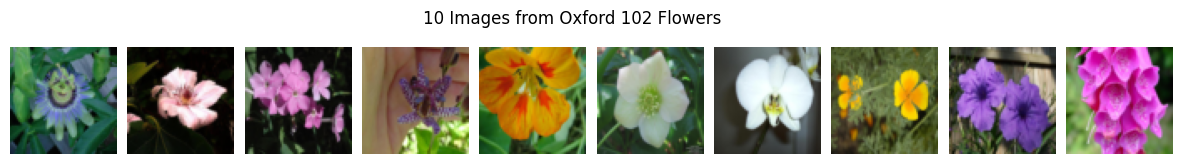

In [5]:
# 10개만 시각화해서 확인
## 1) batch 하나 준비
dataIterator = iter(dataloader) # dataloader은 iterable 하지만 iterator는 아님 -> iterator로 만들어주기
images, labels = next(dataIterator) # images, labels에 batch 하나가 담김

## 2) 도화지 정의
fig, axes = plt.subplots(1, 10, figsize=(15, 3)) # fig: 전체 도화지, axes: 각각의 칸(numpy array)
plt.subplots_adjust(wspace=0.1) # 이미지 사이 간격

## 3) 그림 그리기
for i in range(10):
  img = images[i]
  img = (img * 0.5) + 0.5 # Normalize 했던거 원래대로 복구
  img = img.permute(1, 2, 0) # (C, H, W) -> (H, W, C)
  axes[i].imshow(img.cpu().numpy()) # numpy(): Tensor -> Numpy Array
  axes[i].axis('off') # 눈금제거

plt.suptitle("10 Images from Oxford 102 Flowers", y=0.8)
plt.show()

## Diffusion Schedule (Forward Process)

In [6]:
# 3가지 diffusion schedules - Linear/Cosine/Offset Cosine
class DiffusionSchedules:
  def __init__(self, T=1000):
    self.T = T
    self.times = torch.linspace(0, 1, T) # [0.000, 0.001, 0.002, ... 0.999, 1.000]

  ## 1) Linear Diffusion Schedules
  ### t 지나면서 beta가 linear 하게 커짐
  def linear_diffusion_schedule(self):
    ## beta 범위 설정
    min_beta = 0.0001
    max_beta = 0.02

    # betas, alphas, alpha_bars
    betas = min_beta + self.times * (max_beta - min_beta)
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0) # coumprod: 누적 곱셈 [2, 3, 5] -> [2, 6, 30]

    # noise, blur rates(tensor)
    noise_rates = torch.sqrt(1 - alpha_bars)
    blur_rates = torch.sqrt(alpha_bars)

    return blur_rates, noise_rates # 앞에 곱하는걸 앞에 썼음.


  ## 2) Cosine Diffusion Schedules
  ### sin^2 + cos^2 = 1 이용한 schedule
  def cosine_diffusion_schedule(self):
    blur_rates = torch.cos(self.times * math.pi / 2)
    noise_rates = torch.sin(self.times * math.pi / 2)

    return blur_rates, noise_rates


  ## 3) Offset Cosine Schedules
  ### 너무 어둡거나 밝은 이미지 생성 방지
  def offset_diffusion_schedule(self):
    min_blur_rate = 0.02
    max_blur_rate = 0.95

    # min, max의 cos 각도
    start_angle = torch.acos(torch.tensor(max_blur_rate))
    end_angle = torch.acos(torch.tensor(min_blur_rate))

    # 각도를 linear하게 세팅해서 sin, cos 사용
    diffusion_angles = start_angle + self.times * (end_angle - start_angle)
    blur_rates = torch.cos(diffusion_angles)
    noise_rates = torch.sin(diffusion_angles)

    return blur_rates, noise_rates

### Schedules Visualizations

In [7]:
# Schedule별 blur_rates, noise_rates 시각화
schedules = DiffusionSchedules(T=1000) # Schdule들 모아놓은 class 호출
linear_blurs, linear_noises = schedules.linear_diffusion_schedule()
cosine_blurs, cosine_noises = schedules.cosine_diffusion_schedule()
offset_blurs, offset_noises = schedules.offset_diffusion_schedule()
diffusion_times = schedules.times

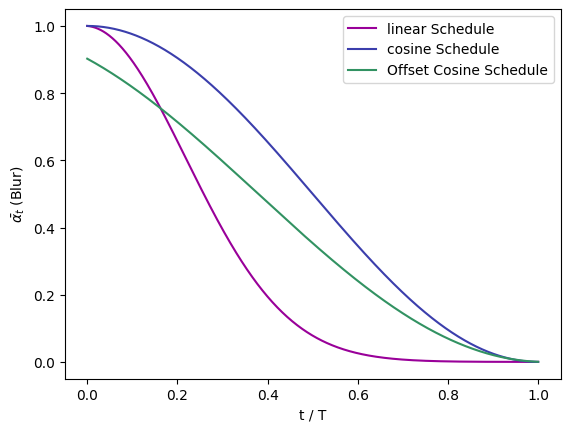

In [8]:
#1. blurs: alpha_t bar
plt.plot(diffusion_times, linear_blurs**2, color="#990099", label="linear Schedule")
plt.plot(diffusion_times, cosine_blurs**2, color="#3b3eac", label="cosine Schedule")
plt.plot(diffusion_times, offset_blurs**2, color="#329262", label="Offset Cosine Schedule")

plt.xlabel("t / T")
plt.ylabel(r"$\bar{\alpha_t}$ (Blur)")
plt.legend()
plt.show()

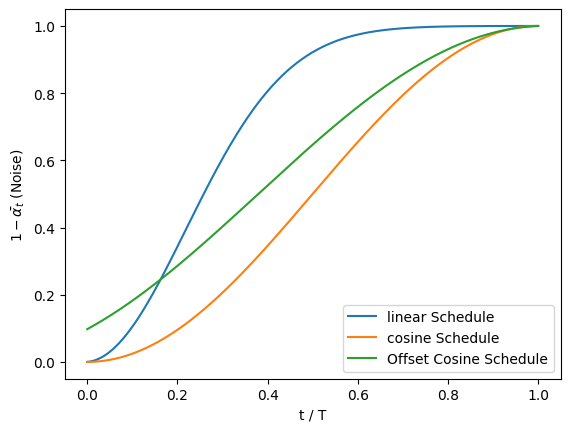

In [9]:
#2. noises: 1 - alpha_t bar
plt.plot(diffusion_times, linear_noises**2, label="linear Schedule")
plt.plot(diffusion_times, cosine_noises**2, label="cosine Schedule")
plt.plot(diffusion_times, offset_noises**2, label="Offset Cosine Schedule")

plt.xlabel("t / T")
plt.ylabel(r"$1-\bar{\alpha_t}$ (Noise)")
plt.legend()
plt.show()

## Build Model

### Sinusoidal Embedding

In [10]:
class SinusoidalTimeEmbedding(nn.Module):
  # class가 호출되면 -> __init__실행 -> nn.Module(pytorch)의 __init__ 실행
  def __init__(self, dim):
    super().__init__()  # super(): 상속받은 부모 클래스인 nn.Module
    self.dim = dim  # self: SinusoidalTimeEmbedding로 만든 instance

  def forward(self, time):
    # input: time - (Batch_Size, ) shape의 1D tensor
    # output: embeddings - (Batch_Size, dim) shpae의 2D tensor

    device = time.device # time이 있을 공간(CPU or GPU)이 나중에 연산을 할 기준 공간

    # frequency: 1 / 10000^(2i / dim) -> 1 / 10000^(i / half_dim - 1) [0부터 시작하니까]
    # log 씌워서 계산 (컴퓨터가 계산하기 더 좋다고 함)
    # - {i / (half_dim - 1)} * log(10000) = -i * {log(10000) / half_dim - 1}

    ## 1. half_dim 계산
    half_dim = self.dim // 2

    ## 2. log(10000) / half_dim - 1
    pre_frequency = math.log(10000) / (half_dim - 1)

    ## 3. i 만들기
    i = torch.arange(half_dim, device=device)

    ##4. frequency 완성
    frequency = torch.exp(-i * pre_frequency)

    # time(Batch_size, )와 frequency(half_dim, ) 텐서 변형해서 행렬곱 -> half_embeddings(Batch_size, half_dim)
    half_embeddings = time[:, None] * frequency[None, :]

    # half_embeddings에 sin, cos 적용해서 수평으로 붙이기 -> embeddings(Batch_size, dim) 완성
    embeddings = torch.cat((half_embeddings.sin(), half_embeddings.cos()), dim=-1)

    return embeddings

#### Visualization

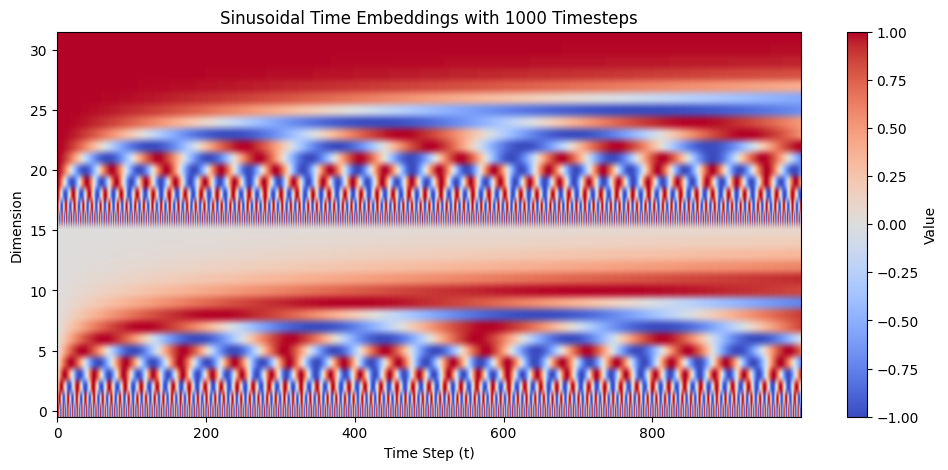

In [18]:
# instance
embedding_dim = 32
time_embedder = SinusoidalTimeEmbedding(embedding_dim) # sinusoidal 인스턴스 생성(32차원으로)
times_sample = torch.arange(1000) # t = 0 ~ 999
embeddings = time_embedder(times_sample) # time_embedder.forward() 안 해도 forward 호출해준다 (pytorch에 call함수로 잘 설계돼있다)

# plot
plt.figure(figsize=(12, 5))
embedding_matrix = embeddings.cpu().numpy().T # embedding을 transpose -> x축: t, y축: dim
# aspect='auto': 픽셀 하나 정사각형 고집 부리지말고 figsize에 맞춰서 꽉 채워라
# origin='lower': 수학 그래프 그리듯이 원점을 가장 아래에 둬라
plt.imshow(embedding_matrix, aspect='auto', cmap='coolwarm', origin='lower')
plt.title("Sinusoidal Time Embeddings with 1000 Timesteps")
plt.xlabel("Time Step (t)")
plt.ylabel("Dimension")
plt.colorbar(label="Value")
plt.show()

### Residual Block

##### Normalization 정리
(N=64, C=64, H=64, W=64) 기준
- **Batch Norm**: Batch 1 안에서 Channel 1을 끌어모아서 모든 픽셀에 대해 평균, 표준편차 구함 -> Batch 1 안에서 C(채널 개수)개의 평균과 표준편차 나옴 -> N 고정, C고정
- **Layer Norm**: Img 1에서 모든 픽셀에 대해 평균, 표준편차 구함 -> Batch 하나 당 Batch_Size개의 평균과 표준편차 나옴 -> C, H, W 고정
- **Group Norm**: Img 1, Channel 1, 2 에서 모든 픽셀에 대해 평균, 표준편차 구함 -> 보통 사진 하나 당 그룹을 32개로 고정 -> Batch 하나 당 32 * Batch_Size 개의 평균과 표준편차 나옴 -> N, H, W 고정, C 그룹화 고정

In [20]:
class ResidualBlock(nn.Module):
  def __init__(self, input_channels, output_channels, time_emb_dim, groups=8): # groups: GroupNorm 할 때 그룹개수(32개가 국룰이지만 채널 개수 충분하지 않아서 8로)
    super().__init__()

    # part 1
    ## 3x3 convolution layer에 통과시킨다. padding 1로 줘야 projection 의 사이즈가 원래 이미지 사이즈랑 같아짐
    ## poj_size = img_size - conv_size + 1 에서 conv_size = 3 이므로 poj_size = img_size - 2 -> img_size에 2 더해줘야 같아짐
    self.proj1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)
    ## GroupNorm
    self.norm1 = nn.GroupNorm(groups, output_channels)
    ## Activation function: SiLU = x * sigma(x), where sigma(x) = sigmoid
    self.act1 = nn.SiLU()

    # time embedding part
    self.time_embedding = nn.Sequential(
        nn.SiLU(), # time embedding을 SiLU에 통과시켜서 비선형성 부여
        nn.Linear(time_emb_dim, output_channels) # FFN 통과시켜서 output_channel이랑 time_emb_dim 똑같이 만들어줌
    )

    # part 2
    self.proj2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1)
    self.norm2 = nn.GroupNorm(groups, output_channels)
    self.act2 = nn.SiLU()

    # residual connection part
    ## channel 다르면 1x1 convolution으로 맞춰준다
    if input_channels != output_channels:
      self.connection = nn.Conv2d(input_channels, output_channels, kernel_size=1) # (input_channels, 1, 1)인 kernel을 output_channels개 준비해서 convolution
    else:
      self.connection = nn.Identity() # 그냥 통과(y = x)

  def forward(self, x, t):
    # x(img): (Batch_Size, input_channels, H, W)
    # t: (Batch_Size, time_emb_dim)
    h_for_connection = x # Residual Connection 위해서 저장

    # part 1
    h = self.proj1(x)
    h = self.norm1(h)
    h = self.act1(h)

    # time embedding adding part
    time_emb = self.time_embedding(t) # time embedding 변환 -> (Batch_Size, output_channels)
    h = h + time_emb[:, :, None, None] # time_emb: (Batch_Size, output_channels) -> (Batch_Size, output_channels, 1, 1) (H, W)가 (1, 1)이 아니어도 같은 값 다 더해짐

    # part 2
    h = self.proj2(h)
    h = self.norm2(h)
    h = self.act2(h)

    # residual connection part(return)
    return h + self.connection(h_for_connection)

### Down Block

In [21]:
class DownBlock(nn.Module):
  def __init__(self, input_channels, output_channels, time_emb_dim, groups=8):
    super().__init__()

    # part 1: residual block 2개 쌓기
    self.res_block1 = ResidualBlock(input_channels, output_channels, time_emb_dim, groups)
    self.res_block2 = ResidualBlock(output_channels, output_channels, time_emb_dim, groups)

    # part 2: Downsampling
    self.downsample = nn.Conv2d(output_channels, output_channels, kernel_size=3, stride=2, padding=1) # 두 칸씩 이동해서 픽셀 수 절반으로 줄임

  def forward(self, x, t):
    # x: B(Batch_size, input_channels, H, W)

    # residual block 두 번 통과
    x = self.res_block1(x, t)
    x = self.res_block2(x, t)

    # downsampling
    x = self.downsample(x) # (Batch_Size, output_channels, H/2, W/2)
    return x

### Up Block

In [23]:
class UpBlock(nn.Module):
  def __init__(self, input_channels, output_channels, time_emb_dim, groups=8):
    super().__init__()

    # part1: upsampling
    ## Transposed Convolution: 픽셀 한 칸을 여러 칸으로 흩뿌리기(Convoludtion의 역연산) -> 2배로 커짐
    self.upsample = nn.ConvTranspose2d(input_channels, output_channels, kernel_size=2, stride=2) # 2*2 영역에 뿌리기, 새 도화지에서 2칸씩 이동

    # part2: residual block 2개 쌓기
    self.res_block1 = ResidualBlock(output_channels * 2, output_channels, time_emb_dim, groups) # Residual connection 한 것과 올라온 x 합칠 것
    self.res_block2 = ResidualBlock(output_channels, output_channels, time_emb_dim, groups)

  def forward(self, x, residual, t):
    # x: (Batch_Size, input_channels, H, W) -> down block 거쳐온 이미지
    # residual: (Batch_Size, output_channels, H*2, W*2) -> Down Block에서 저장해둔 것

    # Upsampling(H, W -> 2H, 2W)
    x = self.upsample(x)

    # Concatenation
    ## dim=1 방향: Channel 방향
    ## (B, C, H, W) -> (B, 2C, H, W)
    x = torch.cat([x, residual], dim=1)

    # ResBlock 통과시키기
    x = self.res_block1(x, t)
    x = self.res_block2(x, t)

    return x